TypeError: can only concatenate str (not "function") to str

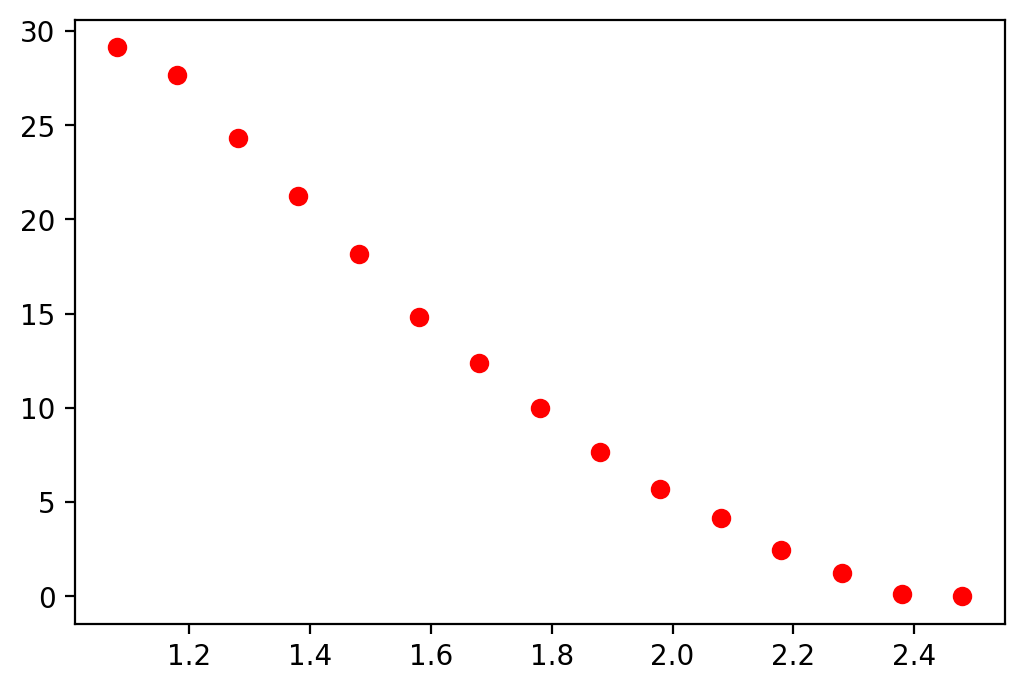

In [11]:
# Plot delay as function of input voltage.

import numpy
import os
import helper
import h5py
from matplotlib import pyplot
from scipy.optimize import curve_fit

figure, axis = pyplot.subplots(dpi = 200)

def get_fit(dir, color, label):
    file_comment = helper.get_file_comment(dir)

    x_input = []
    y_delay = []

    # For all of the files find the delay of its global max.
    
    for [f, input_kV] in file_comment:
        h5file = h5py.File(f, 'r')
        x = h5file['pulserscope_traces_x'][0]
        y = h5file['pulserscope_traces_y'][0]
        
        # Find the global max. Ignore the tails.
        y_max_index = numpy.argmax(y[0:2000])
        
        # I took an extra data point at 0.98, ignore it so both end at 1.08.
        if not (dir == './longcable/' and input_kV == 0.98):
            x_input.append(input_kV)
            y_delay.append(x[y_max_index])

    # Make the 2.48 peak the zero time, measure delay of others.
    y_delay -= y_delay[0]
    axis.plot(x_input, y_delay, 'o', color = color)

    # Fit to exponential.
    def fit_exp(x, a, c, d):
        return a*numpy.exp(c*x)+d
    
    # Fit to tanh.
    def fit_tanh(x, a, b, c):
        return a * numpy.tanh(x * b) + c
    
    def fit(func, initial_param, dashes):
        popt, pcov = curve_fit(func, x_input, y_delay, p0 = initial_param)
        x_fit = numpy.linspace(1.08, 2.48)
        y_fit = func(numpy.asarray(x_fit), *popt)
        axis.plot(x_fit, y_fit, dashes, color = color, label = label + func)
        
    fit(fit_exp, (1, -0.01, 0), '-', 'Exponential')
    fit(fit_tanh, (1, -0.01, 0), '--', 'Tanh)
    
    
get_fit('./shortcable/', 'r', 'Short')
get_fit('./longcable/', 'b', 'Long')

axis.set_title('Pulse delays as function of input voltage')
axis.set_xlabel('Input power source voltage (kV)')
axis.set_ylabel('Delay after 2.48 kV peak (Nanosecond)')
axis.legend()